In [1]:
import time, sys, joblib

import pandas as pd

sys.path.append('/home/yilingh/SI-Interaction')
from selectinf.Simulation.plotting_helpers import *
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [2]:
from operator import le, ge
def filter_pval_dict_new(target_dict, threshold=0.05, operator=le, p_flag="pivot"):
    grouped_targets = pd.DataFrame(target_dict).groupby(['parameter', 'method'])
    filtered_dict = {}
    # Filter by 
    for name, group in grouped_targets:
        # Subset the selected targets
        selected_targets_id = operator(np.abs(group['target']), threshold)
        selected_targets = group[p_flag][selected_targets_id]
        # Then filtered_dict.keys must be a dictionary
        if name[0] in filtered_dict.keys():
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        else:
            filtered_dict[name[0]] = {}
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        
    return filtered_dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_MSE(oper_char):
    specific_method = "MLE"  # Replace with the name of your method
    
    # Create a modified DataFrame
    df_modified = oper_char.copy()
    
    # For the specific method, keep "tau" values separate
    # For other methods, set "tau" to a single category, e.g., "All"
    df_modified['prop'] = df_modified.apply(
        lambda row: row['prop'] if row['method'] == specific_method else 'Naive/DS', axis=1
    )
    
    # Plotting
    sns.boxplot(x='method', y='MSE', hue='prop', data=df_modified, showmeans=True)
    plt.xlabel("Method")
    plt.ylabel("MSE")
    plt.title("Boxplot of MSE by Method and prop")
    plt.show()


In [3]:
def combine_dicts(dict, new_dict):
    for key in dict.keys():
        dict[key] = dict[key] + new_dict[key]
        
    return dict

In [4]:
def combine_nested_dicts(dict, new_dict):
    combined_dict = {}
    for key in dict.keys():
        combined_dict[key] = combine_dicts(dict[key], new_dict[key])
    
    return combined_dict

# Vary sparsity with weak Hierarchy

In [7]:
n_task_per_file = 20
n_files = 10
base_dir = "toy_weak_"
files_list = []
for i in range(n_files):
    dir = base_dir + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    files_list.append(dir)

In [8]:
oper_char_full = None
ds_rank_def_count_full = None
target_dict_full = None
pval_dict_full = None
MSE_dict_full = None

for path in files_list:
    ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char = joblib.load(path)
    # Combine ds_rank_def_count
    if not ds_rank_def_count_full:
        ds_rank_def_count_full = ds_rank_def_count
    else:
        ds_rank_def_count_full = combine_dicts(ds_rank_def_count_full, ds_rank_def_count)
    # Combine target_dict
    if not target_dict_full:
        target_dict_full = target_dict
    else:
        target_dict_full = combine_dicts(target_dict_full, target_dict)
    if not pval_dict_full:
        pval_dict_full = pval_dict
    else:
        pval_dict_full = combine_nested_dicts(pval_dict_full, pval_dict)
    # Combine MSE_dict
    if not MSE_dict_full:
        MSE_dict_full = MSE_dict
    else:
        MSE_dict_full = combine_dicts(MSE_dict_full, MSE_dict)
    # Combine oper_char
    if not oper_char_full:
        oper_char_full = oper_char
    else:
        oper_char_full = combine_dicts(oper_char_full, oper_char)

In [9]:
ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char = joblib.load(files_list[0])

In [10]:
pd.DataFrame(oper_char)

,coverage rate,avg length,method,prop,rho,signal,main signal,target,power
0,0.962963,17.663855,Naive,0.5,0.5,2,2,9.110525,0.074074
1,0.783784,16.868655,Data Splitting,0.5,0.5,2,2,9.151770,0.432432
2,0.900000,25.455288,MLE,0.5,0.5,2,2,9.106549,0.100000
3,0.981481,14.349618,Naive,0.5,0.5,2,2,2.720916,0.111111
4,0.981481,19.298247,Data Splitting,0.5,0.5,2,2,2.213479,0.092593
...,...,...,...,...,...,...,...,...,...
281,0.785714,47.252061,Data Splitting,0.9,0.5,2,2,12.171234,0.342857
282,0.925926,46.734733,MLE,0.9,0.5,2,2,2.381120,0.074074
283,0.870588,18.081693,Naive,0.9,0.5,2,2,10.318920,0.117647
284,0.957143,65.861652,Data Splitting,0.9,0.5,2,2,9.959677,0.042857


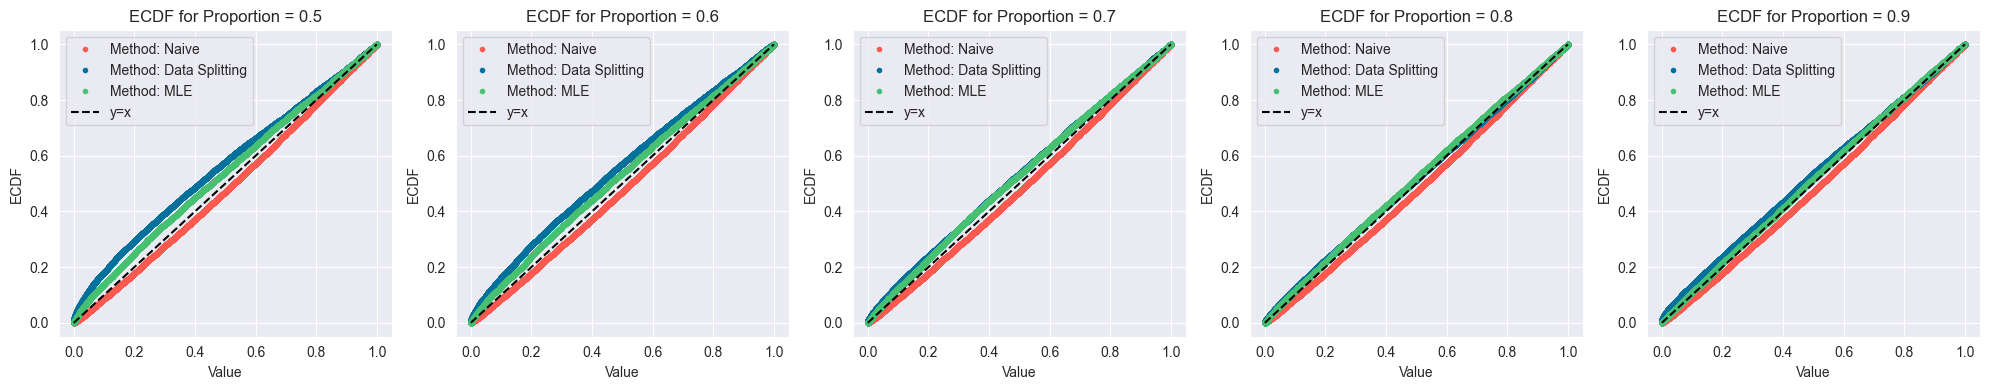

In [11]:
plot_ecdfs(pval_dict_full, xaxis="Proportion")

In [12]:
## Plotting dict: SNR - Method - List of pvals
filtered_dict = filter_pval_dict_new(target_dict, threshold = 0,
                                     operator=ge)

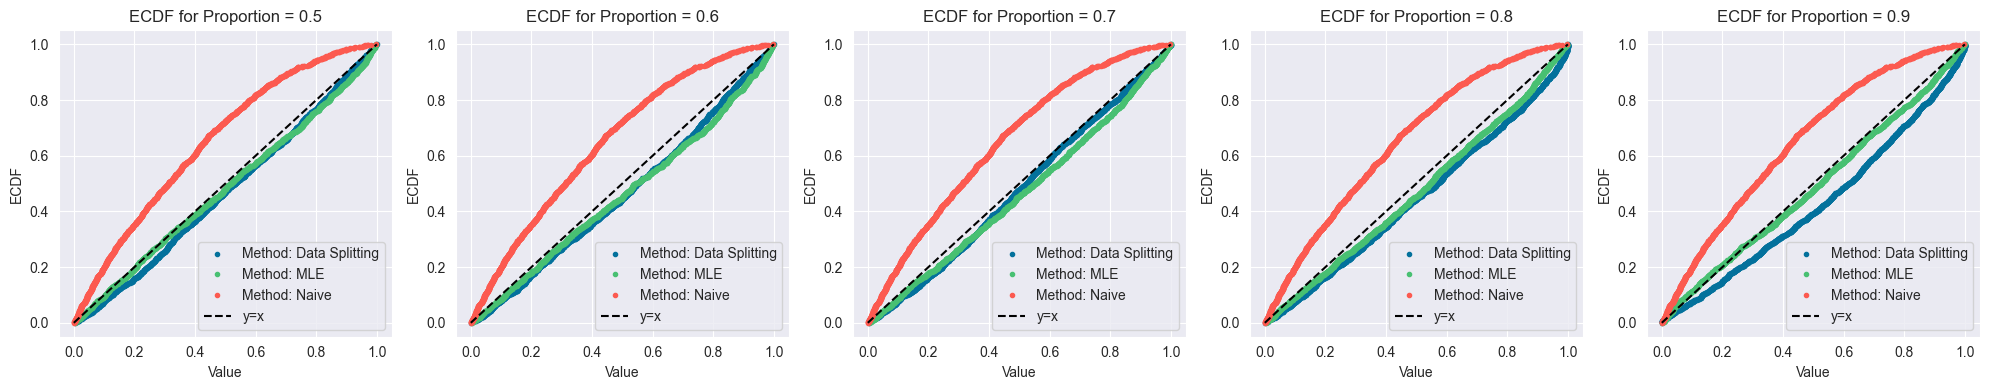

In [13]:
plot_ecdfs(filtered_dict, xaxis="Proportion")

In [14]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })

Text(0, 0.5, 'Average Length')

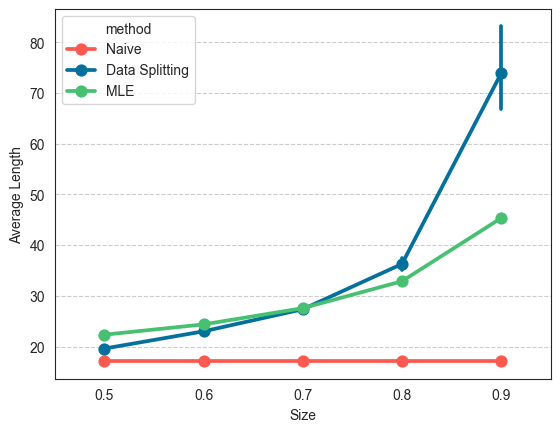

In [15]:
sns.pointplot(x=pd.DataFrame(oper_char_full)["prop"],
              y=pd.DataFrame(oper_char_full)["avg length"],
              hue=pd.DataFrame(oper_char_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(10,35)
plt.xlabel(r"Size")
plt.ylabel("Average Length")

Text(0, 0.5, 'Test MSE')

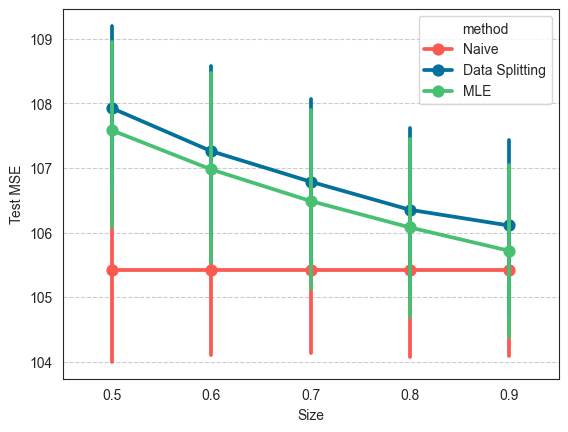

In [16]:
sns.pointplot(x=pd.DataFrame(MSE_dict_full)["prop"],
              y=pd.DataFrame(MSE_dict_full)["MSE"],
              hue=pd.DataFrame(MSE_dict_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(25,30)
plt.xlabel(r"Size")
plt.ylabel("Test MSE")

# Applying BY Correction to the p-values

In [17]:
from collections import defaultdict
from scipy.stats import false_discovery_control


def add_BY_pval_by_method_and_index(data):
    # Check if BYpval is there
    if "BYpval" in data.keys():
        return
    # Assuming your dictionary is named 'data' and structured as described
    methods = data['method']
    indices = data['index']
    pvals = data['pval']

    # Initialize default dictionaries to collect p-values and positions for each (method, index) pair
    pvals_dict = defaultdict(list)
    pos_dict = defaultdict(list)

    # Iterate over the data and populate the dictionaries
    for i, (method, index, pval) in enumerate(zip(methods, indices, pvals)):
        key = (method, index)
        pvals_dict[key].append(pval)
        pos_dict[key].append(i)

    # Initialize BYpvals array with the same length as pvals
    BYpvals = [0] * len(pvals)  # or use numpy.zeros_like(pvals) if pvals is a numpy array

    # Apply BY correction and assign back to positions
    for key in pvals_dict:
        pvals_list = pvals_dict[key]
        positions = pos_dict[key]
        corrected_pvals = false_discovery_control(pvals_list, method='by')
        for pos, by_pval in zip(positions, corrected_pvals):
            BYpvals[pos] = by_pval

    # Add BYpvals to the original data dictionary
    data['BYpvals'] = BYpvals

    # Now, pvals_dict contains lists of p-values for each unique (method, index) pair

In [18]:
add_BY_pval_by_method_and_index(target_dict_full)

# Calculating Thresholded Power

In [19]:
def calculate_thresholded_power(pvalue, targets, level, threshold=0.05,
                                operator=ge):
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = operator(np.abs(targets), threshold)
    rejection = pvalue < level
    if np.sum(non_null) == 0:
        return 0
    else:
        true_rej = np.sum(non_null * rejection) / np.sum(non_null)

    return true_rej

def calculate_thresholded_power_df(targets_dict,
                                   threshold=0.1,
                                   level=0.1,
                                   operator=ge, 
                                   pval_key = "BYpvals"):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    power_df['thresholded power'] = []
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        power_df['thresholded power'].append(
            calculate_thresholded_power(pvalues, targets, level=level, 
                                        threshold=threshold, operator=operator))
    return power_df

In [20]:
def point_plot_power(oper_char_dfs, x_axis='p', hue='method', 
                     ylim_low=None, ylim_high=None, exclude_naive=True,
                     randomizer_scales=None, x_label=None):
    for i in range(len(oper_char_dfs)):
        oper_char_dfs[i] = oper_char_dfs[i].copy()
        if exclude_naive:
            oper_char_dfs[i] = oper_char_dfs[i][oper_char_dfs[i]['method'] != "Naive"]
    sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })
    # sns.histplot(oper_char_df["sparsity size"])
    # plt.show()
    n_subplots = len(oper_char_dfs)
    # cols = int(np.ceil(n_subplots / 2))
    cols = n_subplots

    fig = plt.figure(figsize=(cols * 5, 6))

    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    # Create each subplot
    for i in range(1, n_subplots + 1):
        # ax = fig.add_subplot(2, cols, i) #two rows
        ax = fig.add_subplot(1, cols, i)  # one row
        if hue is not None:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          hue=oper_char_dfs[i-1][hue],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
            ax.set_title("Randomizer Scale:" + str(randomizer_scales[i-1]))
        else:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
        if ylim_low is not None and ylim_high is not None:
            ax.set_ylim([ylim_low, ylim_high])

        ax.legend().set_visible(False)

    handles, labels = ax.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)

    fig.subplots_adjust(bottom=0.3)
    fig.legend(handles, labels, loc='lower center', ncol=n_subplots,
               prop={'size': 15})

    # cov_plot.legend_.remove()
    # len_plot.legend_.remove()

    # plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    if x_label is not None:
        plt.xlabel(x_label)
    plt.show()

In [21]:
power_threshold = 1
power_df1 = calculate_thresholded_power_df(targets_dict=target_dict_full, 
                                           threshold=power_threshold, level=0.1,
                                           operator=ge, pval_key="BYpvals")

In [22]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

Text(0, 0.5, 'Thresholded Power')

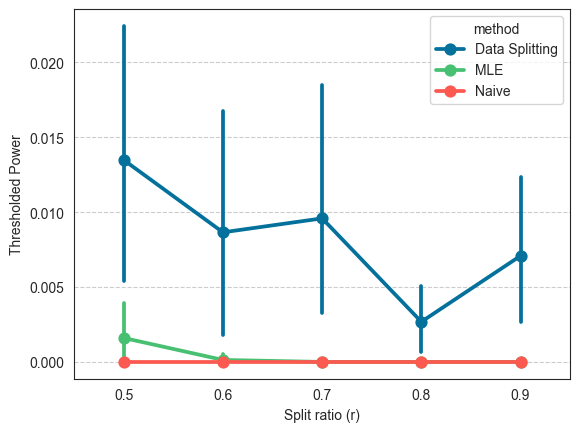

In [23]:
df = pd.DataFrame(power_df1)
#df = df[df["method"] != "Naive"]
sns.pointplot(x=df["parameter"],
              y=df["thresholded power"],
              hue=df["method"], markers='o',
              palette=my_palette)
plt.xlabel("Split ratio (r)")
plt.ylabel("Thresholded Power")

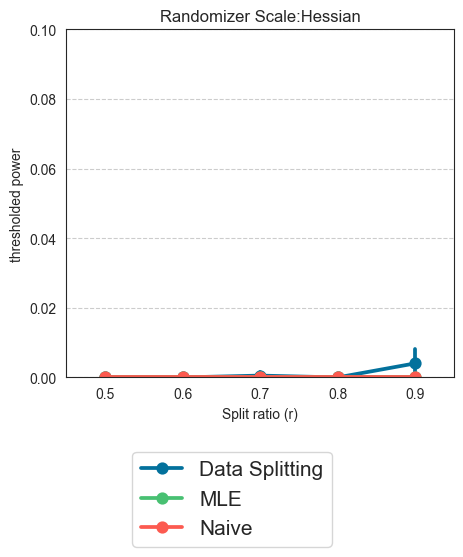

In [24]:
power_threshold = 1
FDP_df1 = calculate_thresholded_power_df(targets_dict=target_dict_full,
                                           threshold=power_threshold, level=0.1,
                                           operator=le, pval_key="BYpvals")
point_plot_power(oper_char_dfs=[pd.DataFrame(FDP_df1)],
                 x_axis="parameter",
                 hue="method", ylim_high=0.1, ylim_low=0,
                 randomizer_scales=["Hessian"], exclude_naive=False,
                 x_label="Split ratio (r)")

(0.0, 10.0)

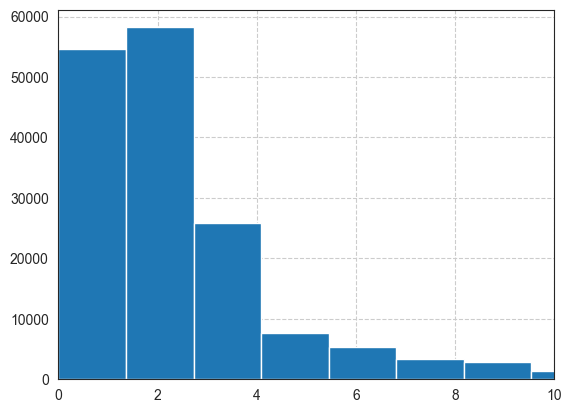

In [25]:
plt.hist(np.abs(target_dict_full['target']), bins=100)
plt.xlim(0,10)